## Второй этап

Теперь нам известна эволюционно устойчивая стратегия поведения $x=A+Bcos(2\pi \cdot t)$
$$A=-85, B=-50$$
Составим вектор вертикальны
$$x^*=(x(0), x(\frac{t}{n}), x(\frac{2t}{n}),...,x(\frac{nt}{n}))$$
$$t\in(0,1)$$

In [1]:
import numpy as np

A = -85
B = -50
C0 = 60
C = 140

def x(t):
    return A + B * np.cos(2 * np.pi * t)

n = 10

x_star = [x(t) for t in np.arange(0, 1 + 1/n, 1/n)]

Сгенерируем новые стратегии поведения по такому принципу:

deВыберем случайное число от 1 до $n$, обозначим его $k$. Теперь выберем $k$ случайных различных чисел $m_i$, $i=1,..k$ от $m_i \in \{1,...,n\}$ и проведем случайные сдвиги $c_{m_i}$ по координатам $x_{m_i}$. Таким образом генерируется новая стратегия поведения.  

In [2]:
from random import randint, seed
from time import clock


def gen_k_numbers(k):
    m = []
    i = 1
    while len(m) < k:
        seed(clock() * i)
        i += 1
        new_num = randint(0, n - 1)
        if new_num not in m:
            m.append(new_num)
    return m

def gen_new_strat(m, seed_n):
    new_strat = x_star[:]
    for i in range(len(m)):
        seed(seed_n * i)
        new_coord = new_strat[m[i]] + (-1) ** randint(0, 1) * randint(1, 100) / 100
        while  new_coord >= 0 or  new_coord <= -C:
             new_coord = new_strat[m[i]] + (-1) ** randint(0, 1) * randint(1, 100) / 100
        new_strat[m[i]] =  new_coord     
    return new_strat

def get_n_strat(l):
    strats = []
    i = 0
    while len(strats) < l:
        k = randint(1, n)
        m = gen_k_numbers(k)
        strat = gen_new_strat(m, i)
        i += 1
        if strat not in strats:
            strats.append(strat)
    return strats

strats_of_behavior = get_n_strat(1000)

C:\Users\Step2Victory\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Напишем функции подсчета интегралов
$$
R(x) = \int\limits_0^1 \alpha E(x)\,dt - \int\limits_0^1 \gamma S_x(x) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (x')^2\,dt  - \int\limits_0^1 \delta G(x)\,dt 
$$ где $x$ - стратегия поведения.

Аппроксимации функций состояния окружающей среды:

$$E = \sigma_1 (x + C), -C < x < 0 \\
S_x = \sigma_2 (x + C) \\
S_t=cos(2\pi t) + 1, 0 < t < 1 \\
G = (x + C_0)^2
$$

In [3]:
sigm1 = 0.25
sigm2 = 0.003



def E(x, t):
    return sigm1 * (x + C)

def S_x_S_t(x, t):
    return sigm2 * (x + C) * (np.cos(2 * np.pi * t) + 1)

def G(x, t):
    return (x + C0) * (x + C0)

def integr(f, x):
    res = 0
    for i in range(len(x) - 1):
        res += (f(x[i + 1], (i + 1) / n) + f(x[i], i / n)) / (2 * n)
    return res

def M_0(x):
    return integr(E, x)

def M_1(x):
    return -integr(S_x_S_t, x)

def M_2(x):
    res = 0
    for i in range(len(x) - 1):
        res += ((x[i + 1] - x[i]) / n) * ((x[i + 1] - x[i]) / n)
    return -res

def M_3(x):
    return -integr(G, x)

def M(x):
    return M_0(x), M_1(x), M_2(x), M_3(x)

Принцип сравнения:
Возьмем две стратегии поведения $u$ и $v$. Можно посчитать отклонение от эволюционно устойчивой стратегии поведения $x^*$. $\epsilon_1 = u - x^*$, $\epsilon_2 = v - x^*$. И сравнить отклонения $\epsilon_1 - \epsilon_2 = u - v$. Если $\epsilon_1 - \epsilon_2 > 0$, значит отклонение $u$ от эволюционно устойчивой стратегии поведения $x^*$ больше, чем отклонение $v$ от $x^*$. Следовательно $v$ более приспособлена, чем $u$, т.к. находится 'ближе' к $x^*$.

In [4]:
import pandas as pd

def get_params(u, v):
    k = [0] * len(u)
    for i in range(len(u)):
        k[i] = u[i] - v[i]
    ok_1 = True
    for elem in k:
        if elem < 0:
            ok_1 = False
            break
    ok_0 = True
    for elem in k:
        if elem > 0:
            ok_0 = False
            break
    zero = True
    for elem in k:
        if elem != 0:
            zero = False
    if zero:
        return False
    if ok_0:
        return [*(np.array(M(u)) - np.array(M(v))), 1]
    if ok_1:
        return [*(np.array(M(u)) - np.array(M(v))), -1]
    return False
    

    
def get_data_train_classifier(strat_b):
    train_data_arr = []
    for i in range(len(strat_b)):
        for j in range(i + 1, len(strat_b)):
            obj1 = get_params(strat_b[i], strat_b[j])
            obj2 = get_params(strat_b[j], strat_b[i])
            if obj1 is not False:
                train_data_arr.append(obj1)
                train_data_arr.append(obj2)
    train_data_classifier = pd.DataFrame(columns=['M_0', 'M_1', 'M_2', 'M_3', 'y'], data=train_data_arr)
    return train_data_classifier

data_train_classifier = get_data_train_classifier(strats_of_behavior)

In [5]:
from sklearn.linear_model import Perceptron


def normalize(X):
    max_M = [0] * 4;
    X_norm = pd.DataFrame()
    max_M[0] = max(X['M_0'])
    max_M[1] = max(X['M_1'])
    max_M[2] = max(X['M_2'])
    max_M[3] = max(X['M_3'])
    X_norm['M_0_norm'] = X['M_0'] / max_M[0]
    X_norm['M_1_norm'] = X['M_1'] /  max_M[1]
    X_norm['M_2_norm'] = X['M_2'] /  max_M[2]
    X_norm['M_3_norm'] = X['M_3'] /  max_M[3]
    return X_norm, max_M;


X = data_train_classifier.drop('y', axis=1)
y = data_train_classifier['y']


X_normalized, max_M = normalize(X);

In [6]:
model_norm = Perceptron()
model_norm.fit(X_normalized, y, coef_init=[0,0,0,0])
model = Perceptron()
model.fit(X, y, coef_init=[0,0,0,0])
print()

Веса модели с нормализаванными признаками  [-0.4208144796379914, 0.38356552070271305, 0.020499662571558414, -0.32389056935141425]
Веса исходной модели  [-1.904137916914018, 135.5032133339328, 0.013909626329456762, -0.005891823528006618]
Заранее известные коэффициенты lam  [0.5, 1, 2.5e-05, 0.01]
Частота правильных ответов на обучающей выборке  1.0
Косинус угла между векторами lam и model_coef 0.8880192017649902


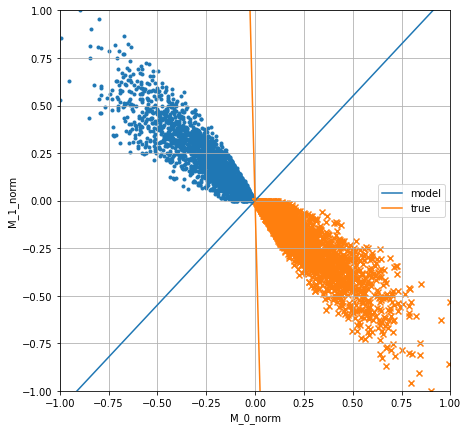

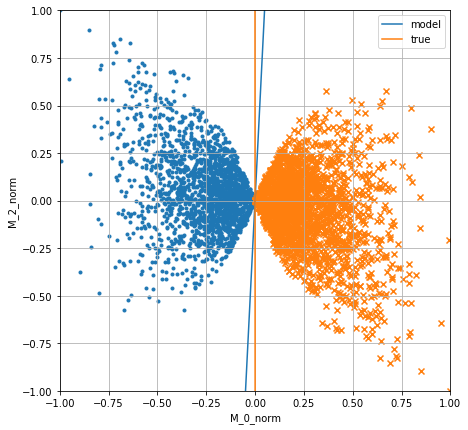

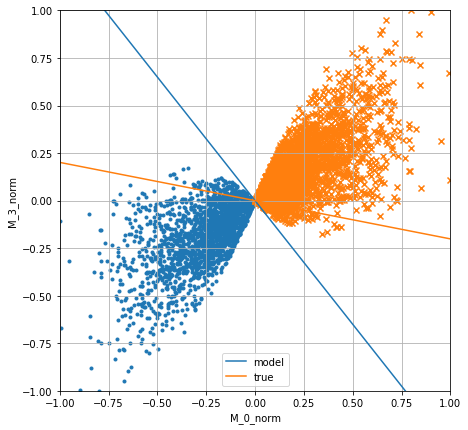

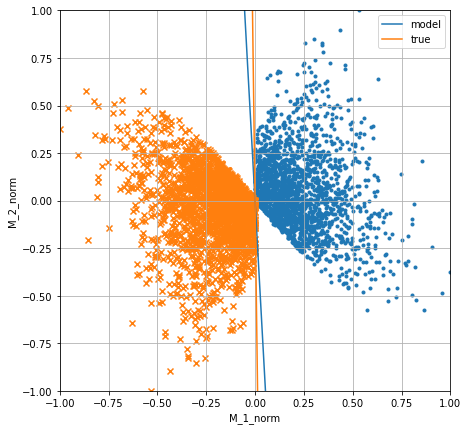

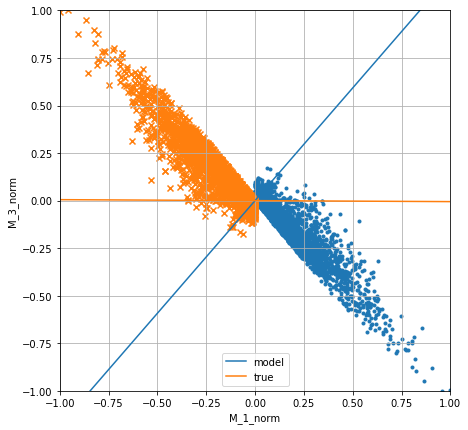

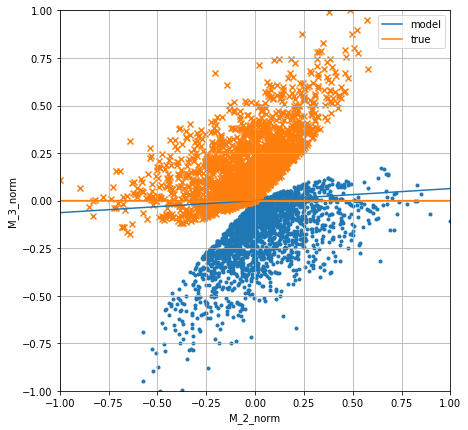

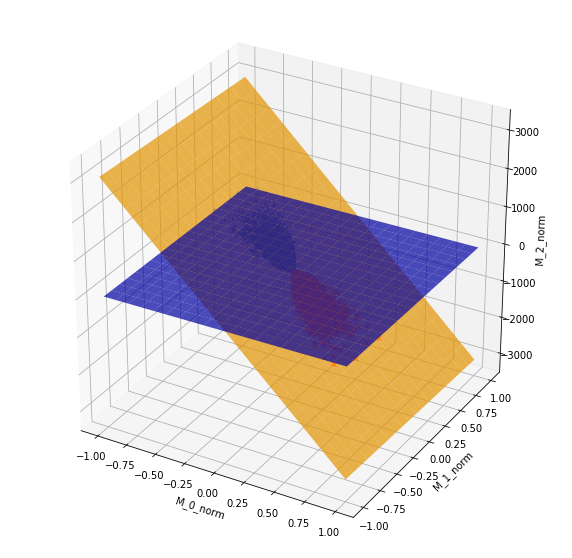

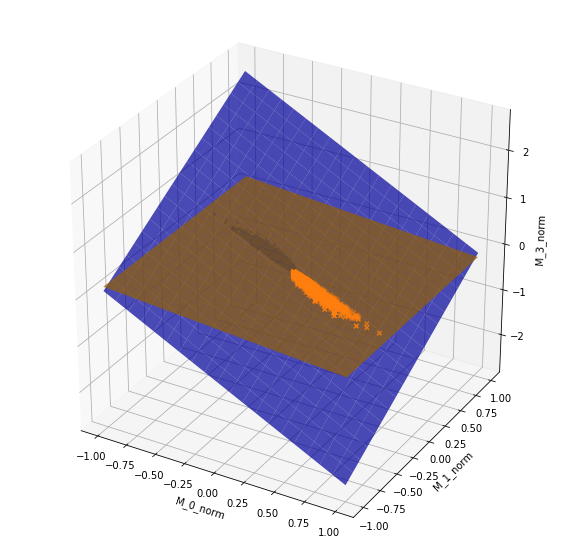

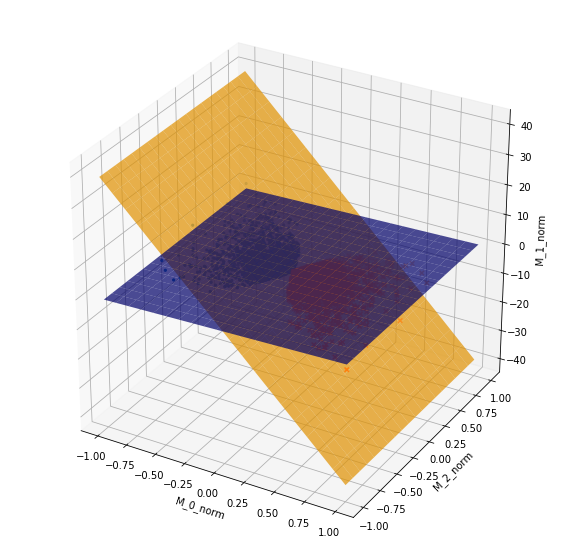

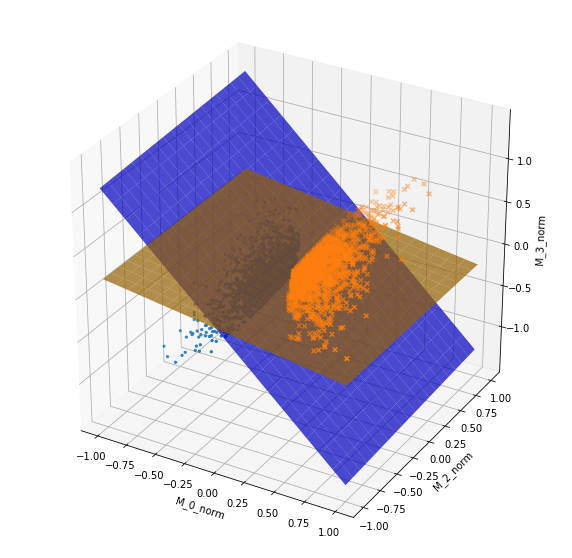

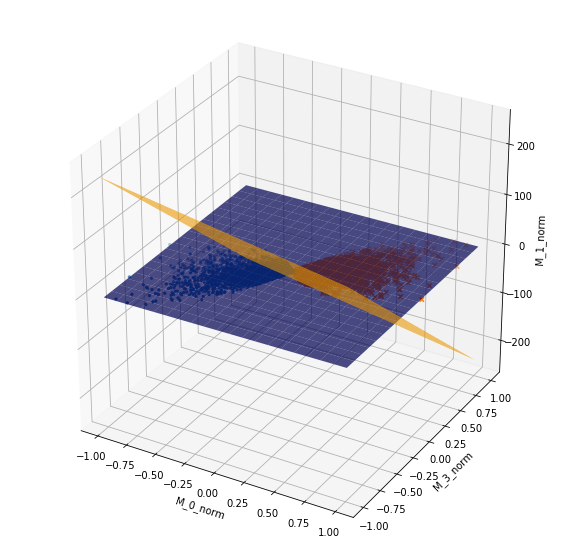

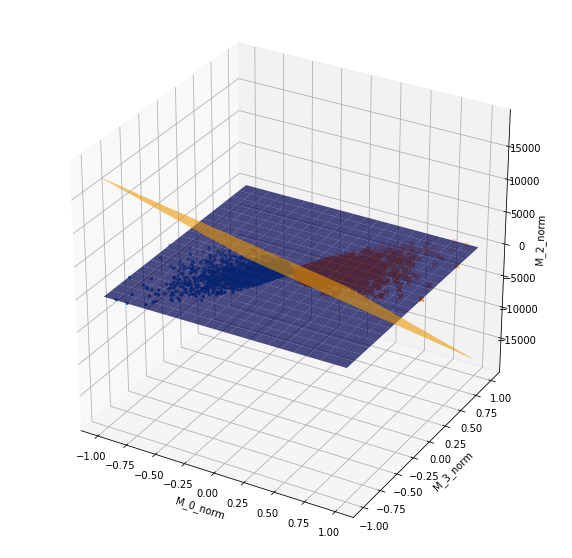

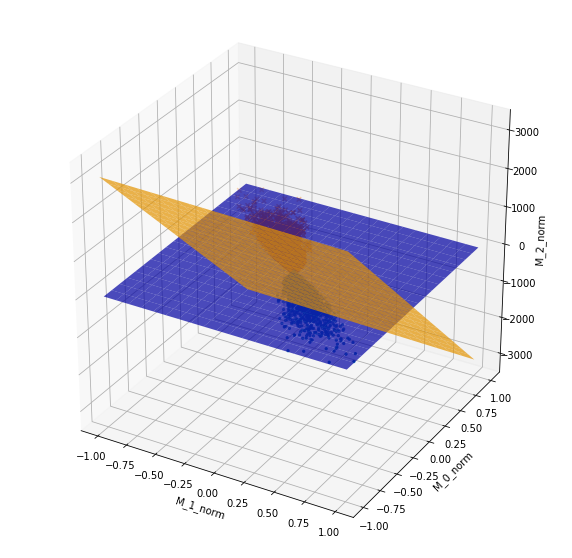

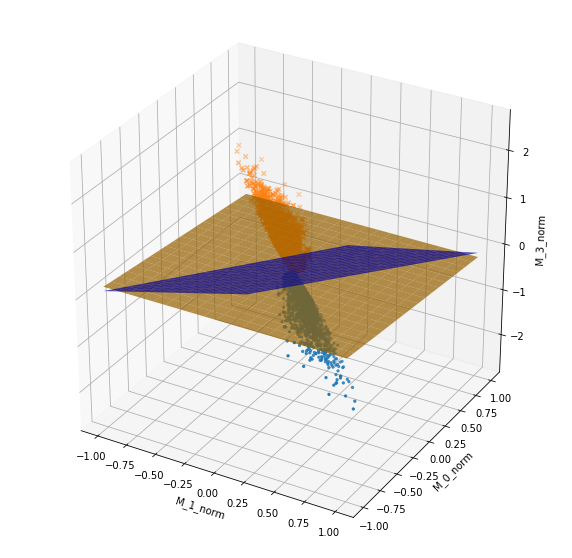

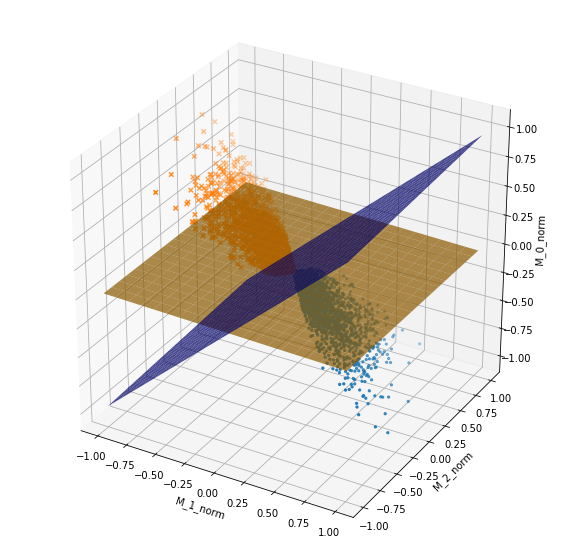

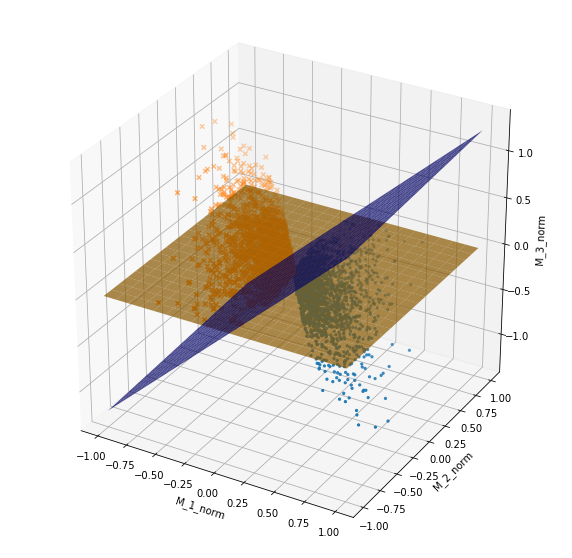

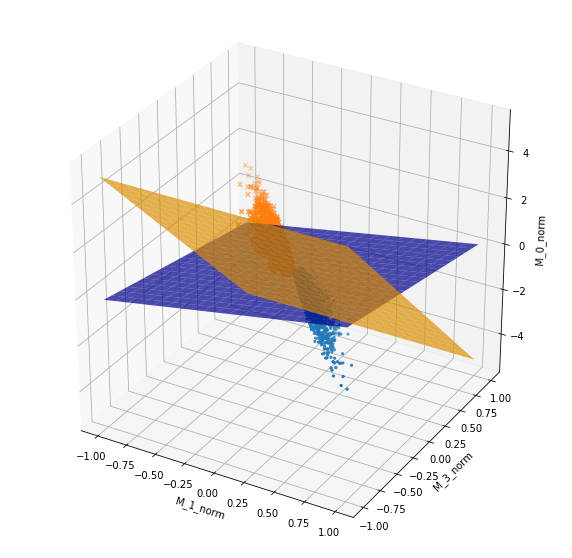

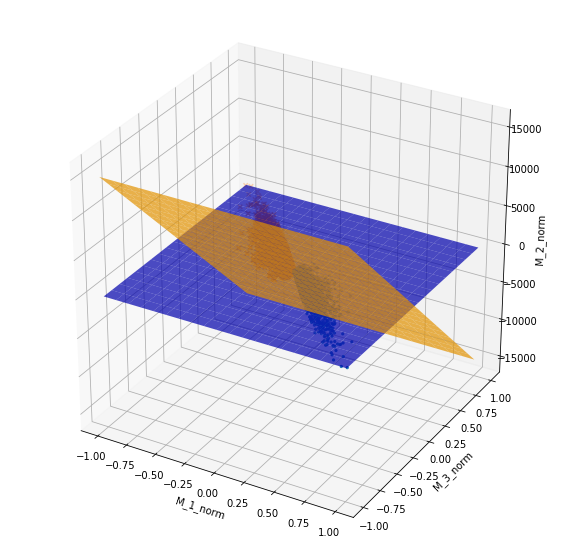

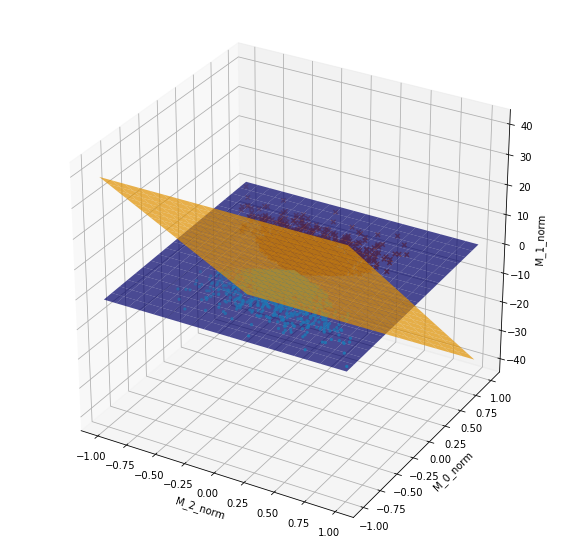

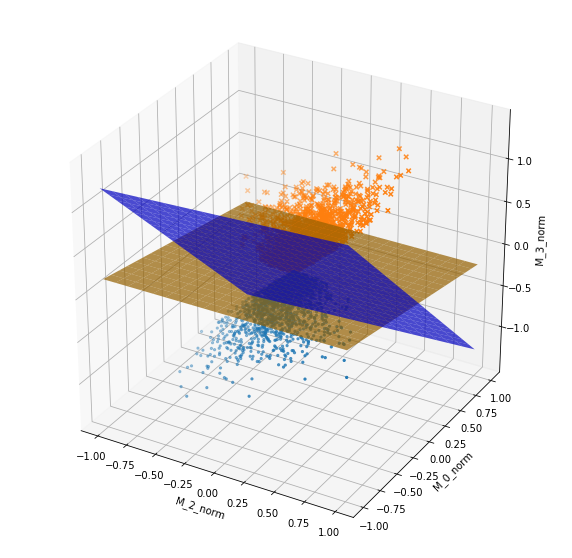

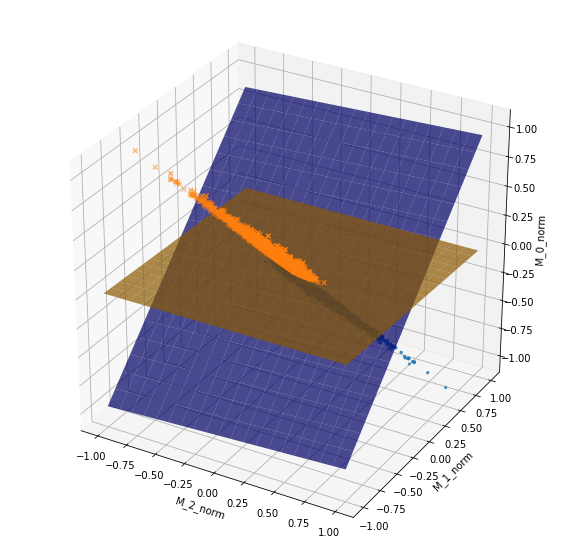

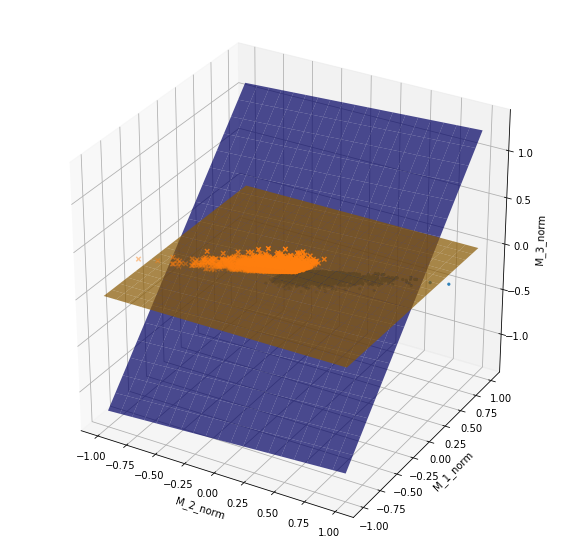

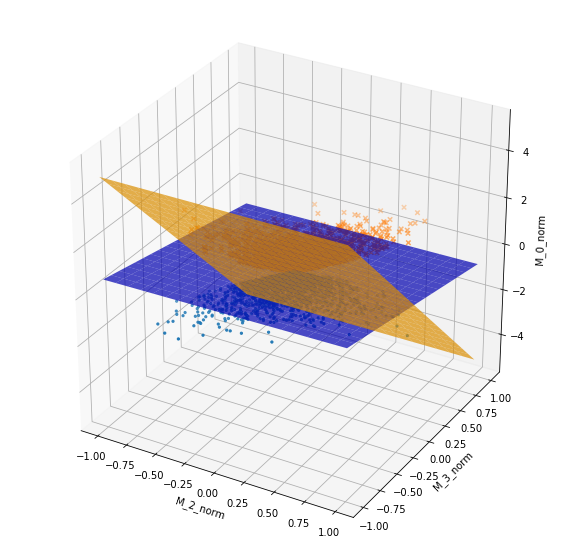

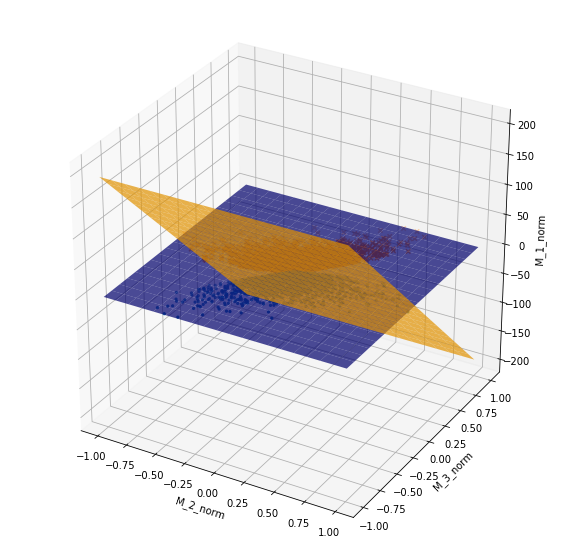

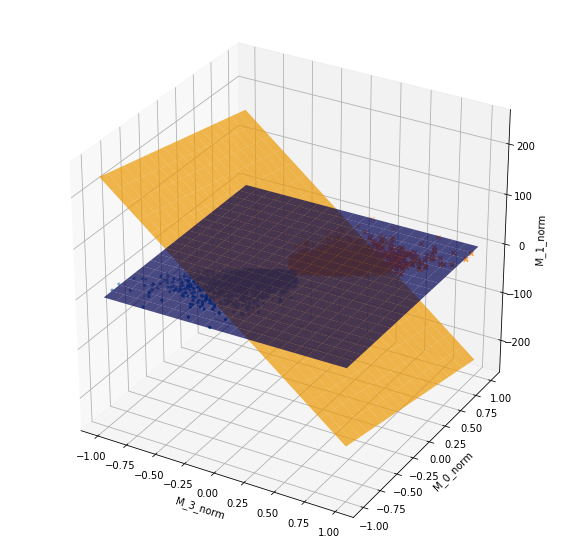

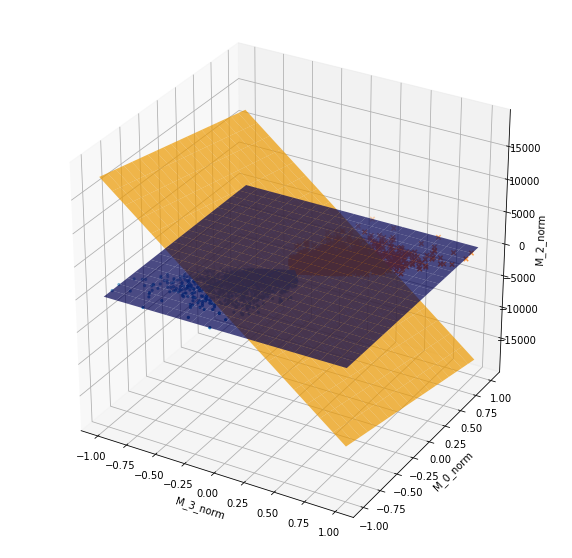

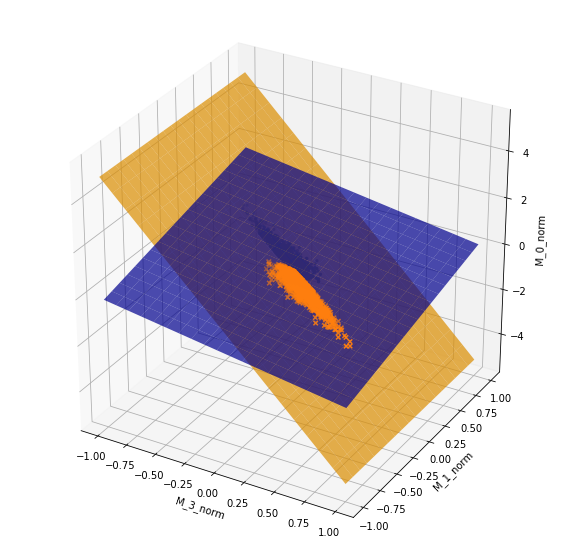

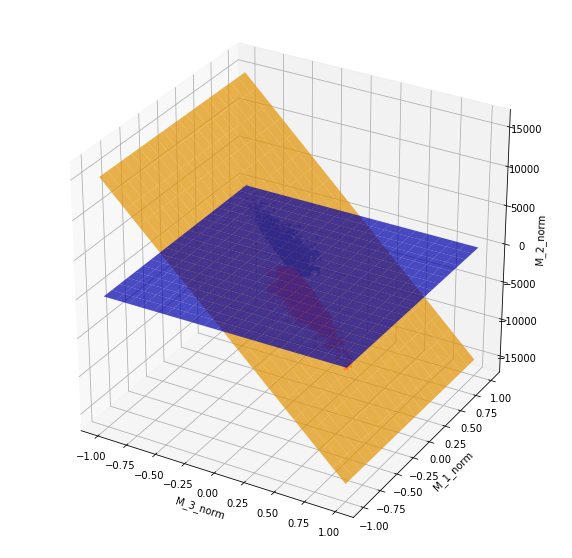

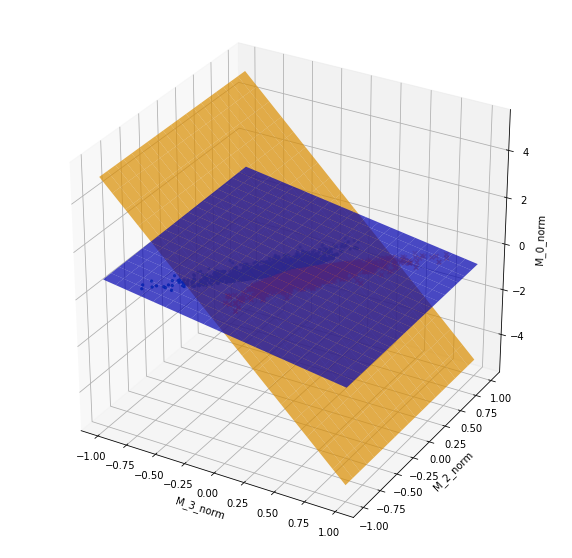

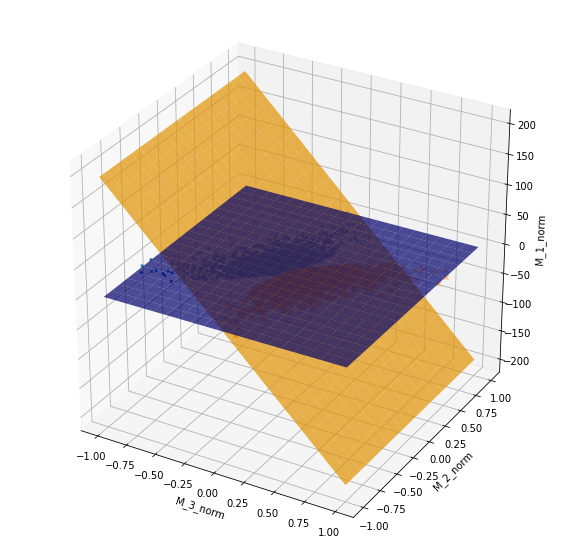

In [7]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

def module(u):
    ans = 0
    for elem in u:
        ans += elem * elem
    return ans

def sc(u, v):
    ans = 0;
    for i in range(len(u)):
        ans += u[i] * v[i];
    return ans;


def cos_n(u, v):
    return sc(u, v) / np.sqrt(module(u) * module(v))



def model_score(model, X, y, lam, show=False, max_M = [1, 1, 1, 1]):
    model_norm = list(model.coef_[0])
    print('Веса модели с нормализаванными признаками ', model_norm)
    model_coef = [0] * 4
    for i in range(4):
        model_coef[i] = model_norm[i] / max_M[i];
    print('Веса исходной модели ', model_coef)
    print('Заранее известные коэффициенты lam ', lam)
    print('Частота правильных ответов на обучающей выборке ', model.score(X, y))
    print('Косинус угла между векторами lam и model_coef', cos_n(model_coef, lam))
    if show:
        X1 = X[y==1]
        X0 = X[y==-1]
        for i in range(len(X.columns)):
            for j in range(i + 1, len(X.columns)):
                x=np.linspace(-1, 1)
                plt.figure(figsize=(7, 7))
                plt.scatter(x = X1[X.columns[i]], y=X1[X.columns[j]], marker='.')
                plt.scatter(x = X0[X.columns[i]], y=X0[X.columns[j]], marker='x')
                plt.plot(x, (-1)* model_norm[i] / model_norm[j] * x, label='model')
                plt.plot(x, (-1) * (lam[i] * max_M[i]) / (lam[j] * max_M[j]) * x, label='true')
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.legend()
                plt.xlabel(X.columns[i])
                plt.ylabel(X.columns[j])
                plt.grid()
                plt.show()
        for i in range(len(X.columns)):
            for j in range(len(X.columns)):
                for k in range(len(X.columns)):
                    if i == j or j == k or i == k:
                        continue
                    u, v = np.mgrid[-1:1:20j, -1:1:20j]
                    fig = plt.figure(figsize=(10, 10))
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(X1[X.columns[i]], X1[X.columns[j]], X1[X.columns[k]], marker='.')
                    ax.scatter(X0[X.columns[i]], X0[X.columns[j]], X0[X.columns[k]], marker='x')
                    ax.plot_surface(u , v, (-1)* (model_norm[i] * u + model_norm[j] * v) / model_norm[k], alpha=0.7, color='blue')
                    ax.plot_surface(u , v, (-1)* ((lam[i] * max_M[i]) * u + (lam[j] * max_M[j]) * v) / (lam[k] * max_M[k]), alpha=0.7, color='orange')
                    ax.set_xlabel(X.columns[i])
                    ax.set_ylabel(X.columns[j])
                    ax.set_zlabel(X.columns[k])
                    plt.show()

                

lam = [0.5, 1, 0.000025, 0.01]
#lam = [0.5 / sigm1, 1 / sigm2, 0.000025, 0.01]
model_score(model_norm, X_normalized, y, lam, True, max_M)